# Balanced Dataset

In this notebook, we train two classifiers on the balanced dataset by selecting a subset of  majority class to match the minority class

##  Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelBinarizer

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

##  Load original data

In [3]:
# Load data
df = pd.read_csv('../raw_data/clean_data.csv')

In [4]:
# Separate the majority and minority classes
majority_class = df[df.FATAL == 0]
minority_class = df[df.FATAL == 1]

In [5]:
# Size of Majority class dataset
majority_class.shape

(3756304, 23)

In [6]:
# Size of Minority class dataset
minority_class.shape

(61309, 23)

## Select a Subset of the Majority Class
We select a subset of majority class to match the minority class

In [7]:
X1, X2, y1, y2 = train_test_split(majority_class, majority_class.FATAL, test_size = 0.0164,
                                  random_state = 42, stratify = majority_class.FATAL)

In [8]:
X2.shape # Selected subset of the majority class

(61604, 23)

## Concatenate the data
We combine the minority class with the selected subset ( X2 ) of the majority class 

In [9]:
df_balanced = pd.concat([minority_class, X2], sort = False)

In [10]:
# Data size
df_balanced.shape

(122913, 23)

In [11]:
# Shuffle the dataset
df_balanced = df_balanced.sample(frac =1).reset_index(drop = True)

## Class distribution

0    50.12
1    49.88
Name: FATAL, dtype: float64

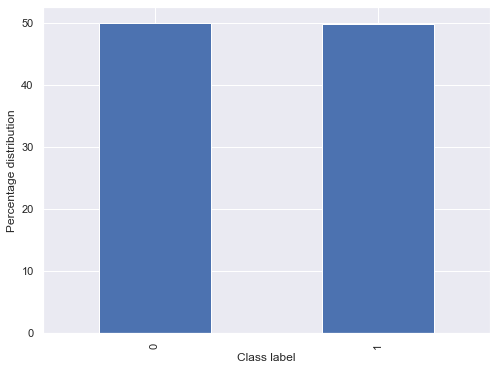

In [12]:
class_dis = (df_balanced.FATAL.value_counts()/len(df_balanced)*100)
class_dis.plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Class label')
plt.ylabel('Percentage distribution')
round(class_dis,2)

## Feature matrix and class label

We separate the feature matrix from the class label

In [13]:
X, y = df_balanced.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1), df_balanced['FATAL']

In [14]:
print('Data size:', X.shape, y.shape)

Data size: (122913, 20) (122913,)


##  Create a Test Set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

In [16]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (98330, 20) (98330,)
Test set size: (24583, 20) (24583,)


In [17]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('*********************************')
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    50.120004
1    49.879996
Name: FATAL, dtype: float64
*********************************
Test set class distribution:
 0    50.120002
1    49.879998
Name: FATAL, dtype: float64


##  Data Pre-processing

In [18]:
# List of categorical attributes
cat_subset = list(X_train.select_dtypes('O'))

# List of numerical attributes
num_subset = list(X_train.select_dtypes('number'))

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_subset]

# Power transform and Standardize the numerical attributes
num_attribs = [([num], PowerTransformer()) for num in num_subset]

# Build a dataframe mapper pipeline
mapper = DataFrameMapper(cat_attribs + num_attribs)

# Fit transform the training set
X_train_scaled = mapper.fit_transform(X_train)

# Only transform the training set
X_test_scaled = mapper.transform(X_test)

In [19]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (98330, 131)
Test set size after pre-processing: (24583, 131)


In [20]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation Predictions

## A-1. Logistic Regression 

In [21]:
log_clf = LogisticRegression()                         
model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.808207 (0.002085)
AUROC: 0.893823
AUPRC: 0.910378
Predicted classes: [0 1]
Confusion matrix:
 [[43198  6085]
 [12774 36273]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     49283
           1       0.86      0.74      0.79     49047

    accuracy                           0.81     98330
   macro avg       0.81      0.81      0.81     98330
weighted avg       0.81      0.81      0.81     98330

****************************************************************************


## A-2. Random Forest

In [22]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.827316 (0.001961)
AUROC: 0.903915
AUPRC: 0.902613
Predicted classes: [0 1]
Confusion matrix:
 [[43523  5760]
 [11220 37827]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84     49283
           1       0.87      0.77      0.82     49047

    accuracy                           0.83     98330
   macro avg       0.83      0.83      0.83     98330
weighted avg       0.83      0.83      0.83     98330

****************************************************************************


# B.  Hyperparameter Tuning and Cost Sensitive Method
 In this section, we shall optimize the **Accuracy** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

## B-1. Logistic Regression

In [23]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'accuracy',verbose = 1, n_jobs = -1)

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Print results
print('Grid search best accuracy score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.9min finished


Grid search best accuracy score: 0.8083799450828841
Grid search best parameters: {'C': 0.5, 'class_weight': 'balanced'}


## B-2. Random Forest

In [24]:
# Range of hyperparameters
params = {'max_features': [1, 0.5,'sqrt', 'log2'], 
          'min_samples_leaf': [1,3,5,10],
         'n_estimators': [500,1000,1500]}

# Randomized search
rf_clf = RandomForestClassifier(random_state = 42,class_weight = 'balanced')           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'accuracy', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Print results
print('Randomized search best accuracy score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 97.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 112.5min finished


Randomized search best accuracy score: 0.8471371910912234
Randomized search best hyperparameters: {'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


## B-3. ROC and PR Curves on the Cross-Validation Training Set

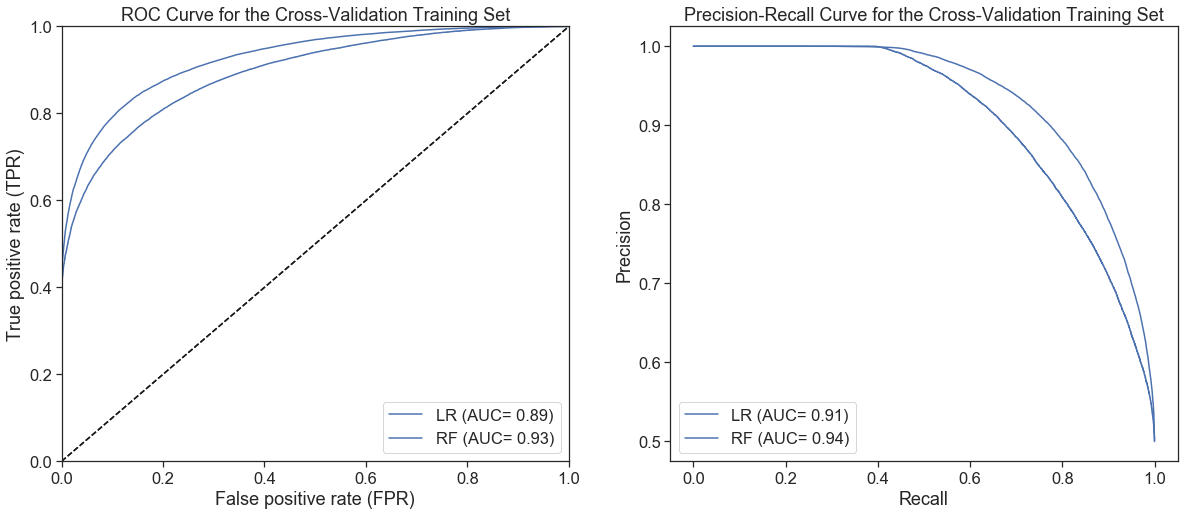

In [25]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for Logistic Regression
Plot_ROC_Curve_and_PRC_Cross_Val(gsearch_log.best_estimator_, X_train_scaled, y_train,
                       color= 'b', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR curves for Random Forest
Plot_ROC_Curve_and_PRC_Cross_Val(rsearch_rf.best_estimator_, X_train_scaled, y_train,
                       color= 'b', label = 'RF (AUC= %0.2f)')

# C. Prediction on the Test Set 

## C-1. Logistic Regression

In [26]:
log_reg_best = gsearch_log.best_estimator_
Test_Prediction(log_reg_best, X_train_scaled, y_train, X_test_scaled, y_test)

****************************************************************************
Test accuracy:  0.808323
AUROC: 0.895559
AUPRC: 0.911544
Predicted classes: [0 1]
Confusion matrix:
 [[10826  1495]
 [ 3217  9045]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     12321
           1       0.86      0.74      0.79     12262

    accuracy                           0.81     24583
   macro avg       0.81      0.81      0.81     24583
weighted avg       0.81      0.81      0.81     24583

****************************************************************************


## C-2. Random Forest

In [27]:
rf_best = rsearch_rf.best_estimator_
Test_Prediction(rf_best, X_train_scaled, y_train, X_test_scaled, y_test)

****************************************************************************
Test accuracy:  0.855266
AUROC: 0.933632
AUPRC: 0.942659
Predicted classes: [0 1]
Confusion matrix:
 [[10956  1365]
 [ 2193 10069]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     12321
           1       0.88      0.82      0.85     12262

    accuracy                           0.86     24583
   macro avg       0.86      0.86      0.86     24583
weighted avg       0.86      0.86      0.86     24583

****************************************************************************


## C-3. ROC and PR Curves on the Test Set

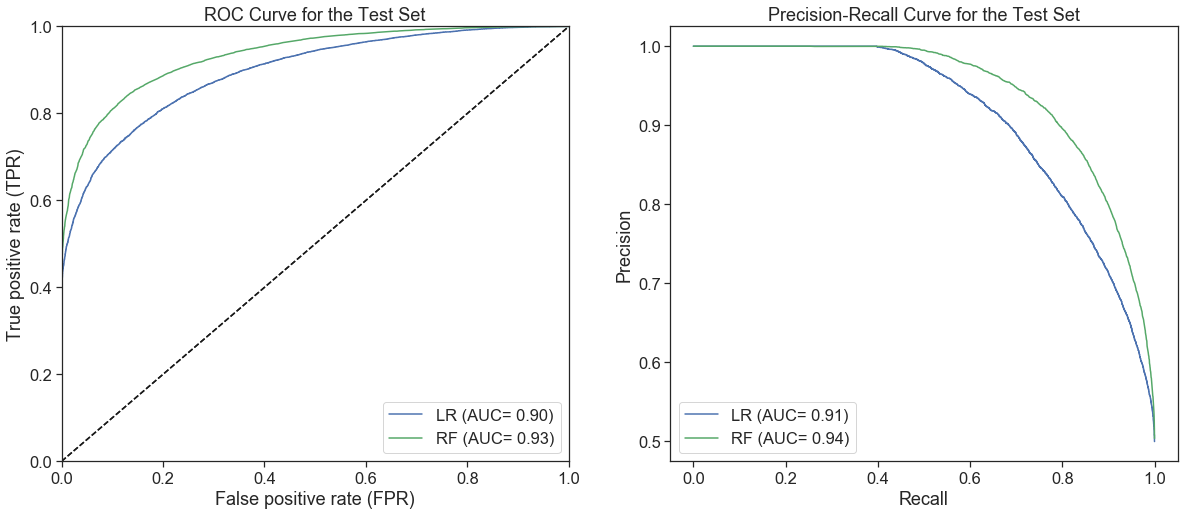

In [28]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for Logistic Regression
Plot_ROC_Curve_and_PRC(log_reg_best, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'b', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR curves for Random Forest
Plot_ROC_Curve_and_PRC(rf_best, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'g', label = 'RF (AUC= %0.2f)')